# Data processing of plume simulation

In [51]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

from decimal import Decimal

RERUN = False #To rerun all computations (False will load from file if they exist)
NCORES_MAX = -2 #Maximal number of cores in use
extension = '.pdf' #fig file extension
#DIR  = 'D:/pdm_data/Bentheimer1000/Plumes/' #On desktop
DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/' #On laptop
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

def v_to_s(v) :
    if v == 0 :
        return 'Inf'
    else :
        return '%.1E' % v

def v_to_pow(v) :
    if v == 0 :
        return 'Inf'
    else :
        power = int(np.log10(v))
        return r'$10^{'+str(power)+'}$'

In [55]:
UREF = 4.6E-06
TREF = 3.0E+01
PECLET    = [0, 1e1]
T_SNAP    = [3.5*10**n_ for n_ in [-5, -4, -3, -2, 0]]
N_SNAP = len(T_SNAP)

FNAMES = {}
for Pe_ in PECLET :
    subdir_ = 'Bentheimer1000/Plume_mode2/Pe'+v_to_s(Pe_)+'/'
    FNAMES[Pe_] = {T_SNAP[n_] : DIR + subdir_ + 'Pe' + v_to_s(Pe_) + '_T'+ v_to_s(T_SNAP[n_]) + '.txt' for n_ in range(N_SNAP)}
print('Peclet values')
print(PECLET)
print('Filenames')
for Pe_ in PECLET :
    for t_ in T_SNAP :
        print(FNAMES[Pe_][t_])

Peclet values
[0, 10.0]
Filenames
C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Bentheimer1000/Plume_mode2/PeInf/PeInf_T3.5E-05.txt
C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Bentheimer1000/Plume_mode2/PeInf/PeInf_T3.5E-04.txt
C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Bentheimer1000/Plume_mode2/PeInf/PeInf_T3.5E-03.txt
C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Bentheimer1000/Plume_mode2/PeInf/PeInf_T3.5E-02.txt
C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Bentheimer1000/Plume_mode2/PeInf/PeInf_T3.5E+00.txt
C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Bentheimer1000/Plume_mode2/Pe1.0E+01/Pe1.0E+01_T3.5E-05.txt
C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Bentheimer1000/Plume_mode2/Pe1.0E+01/Pe1.0E+01_T3.5E-04.txt
C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Bentheimer1000/Plume_mode2/Pe1.0E+01/Pe1.0E+01_T3.5E-03.txt
C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/Bentheimer1000/Plume_mode2/Pe1.0E+01/Pe1

In [56]:
#Data files check
MISSING = False
missing_keys_dms   = []
missing_keys_tsnaps = []
for dms_ in FNAMES :
    for tsnaps_ in FNAMES[dms_] : 
        if not os.path.isfile(FNAMES[dms_][tsnaps_]) :
            MISSING = True
            print('Warning :')
            print('\t' + FNAMES[dms_][tsnaps_])
            print('not found')
            missing_keys_dms.append(dms_)
            missing_keys_tsnaps.append(tsnaps_)
for (dms_,tsnaps_) in zip(missing_keys_dms,missing_keys_tsnaps) :
    del FNAMES[dms_][tsnaps_]
if not MISSING :
    print ('All data have been found :)')

All data have been found :)


In [57]:
dataDNS = {}
print('loading file')
for Pe_ in FNAMES :
    print('\tPe = ' + v_to_s(Pe_))
    dataDNS[Pe_] = {}
    print('\t\t(Tsnap, Np) =', end = ' ')
    for tsnap_ in FNAMES[Pe_] :
        dataDNS[Pe_][tsnap_] = np.loadtxt(open(FNAMES[Pe_][tsnap_], 'r').readlines()[:-1])
        N_P=len(dataDNS[Pe_][tsnap_][:,0])
        print('('+v_to_s(tsnap_)+', '+str(N_P+1)+')', end = ', ')
    print('')

loading file
	Pe = Inf
		(Tsnap, Np) = (3.5E-05, 53453), (3.5E-04, 53453), (3.5E-03, 53453), (3.5E-02, 53453), (3.5E+00, 53449), 
	Pe = 1.0E+01
		(Tsnap, Np) = (3.5E-05, 71095), (3.5E-04, 71090), (3.5E-03, 71089), (3.5E-02, 71082), (3.5E+00, 71074), 


In [58]:
def Extract_pdf(data_, nbins = 500, dst = True) :
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    return pdf_
def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def Return_std(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu = Return_mean(pdf_)
    std  = np.sqrt(np.sum([(x_ - mu)**2*y_ for (x_,y_) in zip(x,y)])/np.sum(y))
    return std

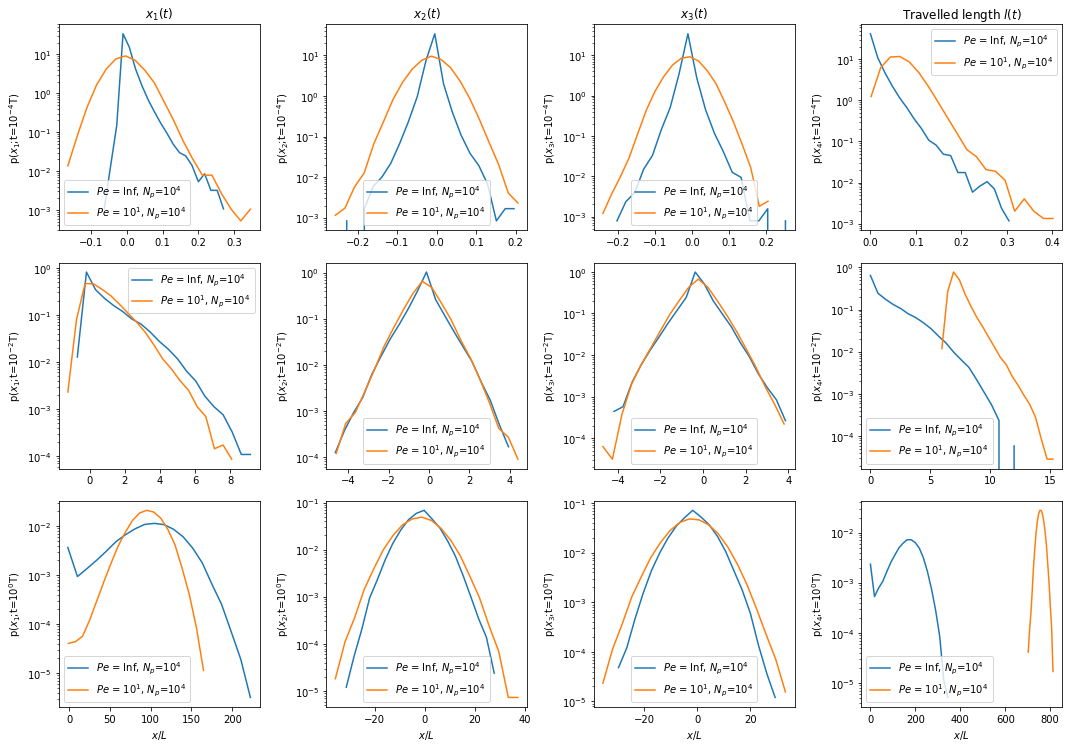

In [64]:
#T_PLOTS = [1.0E0, 1.0E-2, 1.0E-3]
T_PLOTS = [3.5*10**n_ for n_ in [ -4, -2, 0]
]
fig, axs = plt.subplots(len(T_PLOTS),4, figsize = (15,3.5*len(T_PLOTS)))
c_  = 0
nbins_ = 20
plot_hist = False
for d_ in range(4) :
    l_ = 0
    for t_ in T_PLOTS :
        ax = axs[l_,c_]
        ci_ = 0
        for Pe_ in [0.0, 10.0] :
            if t_ in dataDNS[Pe_] :
                N_P_ = len(dataDNS[Pe_][t_][:,d_])
                #xy_  = Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_)
                if plot_hist :
                    ax.hist(dataDNS[Pe_][t_][:,d_], alpha = 0.6, bins = nbins_, density = True, label = '$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+str(N_P_))
                    ax.set_yscale('log')
                else :
                    [x_, y_]  = Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_)
                    ax.semilogy(x_, y_, color = color_cycle[ci_], label = '$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_+1));
                ci_ += 1
            ax.set_ylabel(r'p($x_'+str(d_+1)+'$;t='+v_to_pow(t_/TREF)+'T)')
            ax.legend()
            
        if l_ == 0 : 
            ax.set_title('$x_'+str(d_+1)+'(t)$')
            if c_ == 3 :
                ax.set_title('Travelled length $l(t)$')
        l_ += 1
    c_ += 1
    ax.set_xlabel('$x/L$')
plt.tight_layout()
plt.savefig(DIR+'Figures/early_plume_displacement_pdf'+extension)

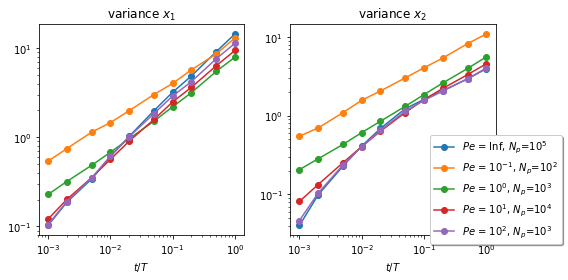

In [28]:
fig, axs = plt.subplots(1,2, figsize = (8,4))
d_ = 0
nbins_ = 100
for d_ in range(2) :
    ax = axs[d_]
    ci_ = 0
    for Pe_ in PECLET :
        if t_ in dataDNS[Pe_] :
            PDF_ = [Extract_pdf(dataDNS[Pe_][t_][:,d_], nbins_) for t_ in T_SNAP]
            STD_ = [Return_std(pdf_) for pdf_ in PDF_]    
            N_P_ = len(dataDNS[Pe_][t_][:,0])
            ax.loglog([tt_ for tt_ in dataDNS[Pe_]],STD_, 'o-', label = '$Pe$ = '+v_to_pow(Pe_) + ', $N_p$='+v_to_pow(N_P_))
    ax.set_title('variance $x_'+str(d_+1)+'$')
    ax.set_xlabel('$t/T$')
ax.legend(loc='upper center', bbox_to_anchor=(1.0, 0.5), shadow=True, ncol=1)
plt.tight_layout()
plt.savefig(DIR+'Figures/variance_x1_x2'+extension)

In [29]:
def count_backflow (snapshot, density = True) :
    x_ = snapshot[:,0]
    N_tot  = len(x_)
    N_back = np.sum(x_ < 0.0)
    if density :
        return 1.0*N_back/N_tot
    else :
        return N_back

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5000075000375002e-05, 1.5000075000375002e-05, 0.0]
[0.36217303822937624, 0.33601609657947684, 0.3440643863179074, 0.3058350100603622, 0.26961770623742454, 0.20967741935483872, 0.13306451612903225, 0.08669354838709678, 0.022222222222222223, 0.00404040404040404]
[0.3113574204692673, 0.27971223021582736, 0.23223021582733813, 0.19245717575932056, 0.14419340912361492, 0.07411138293279608, 0.029797034691233626, 0.007197351374694113, 0.0008634335875665563, 0.0]
[0.1120410163613059, 0.09525065963060686, 0.070716774983517, 0.05515863291043791, 0.039108145802706475, 0.019932177844762623, 0.008691553544494721, 0.003430531732418525, 0.0005653337353484341, 0.0001131328368058829]
[0.031229057767055354, 0.02317792068595927, 0.01660640149993304, 0.01233409304196273, 0.00924561168430926, 0.005357621216180016, 0.002413515687851971, 0.0013401232913428035, 0.0002679528403001072, 0.00013410218586562962]


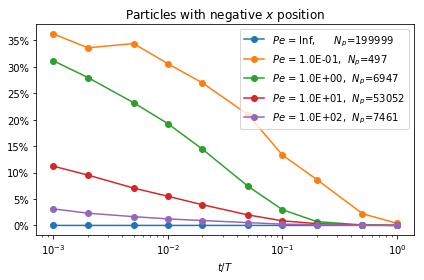

In [31]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(1,1, figsize = (6,4))
T_PLOTS = T_SNAP

for Pe_ in PECLET :
    y_ = [count_backflow(dataDNS[Pe_][t_]) for t_ in T_PLOTS]
    N_P_ = len(dataDNS[Pe_][t_][:,0])
    ax.semilogx(T_PLOTS, y_, 'o-', label = '$Pe$ = '+v_to_s(Pe_) + ',\t $N_p$='+str(N_P_))
    print(y_)
ax.set_title('Particles with negative $x$ position')
ax.set_xlabel('$t/T$')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend()
plt.tight_layout()
plt.savefig(DIR+'Figures/backflow'+extension)

## Markov model 

In [35]:
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}

In [42]:
from scipy.stats import rv_continuous

#Diffusion function from DWM
def d(v,sample) :
    b = sample['b']
    c = sample['c']
    return c*np.exp(b*v)

#Drift function from DWM
def a(v,sample) :
    eps  = 0.1
    p_p1 = p_skew(v+eps,sample); p_m1 = p_skew(v-eps,sample);
    d_p1 = d(v+eps,sample);      d_m1 = d(v-eps,sample);
    d_   = d(v,sample);
    grad = (np.log(p_p1 * d_p1)-np.log(p_m1 * d_m1))/(2.0*eps)
    return d_/2.0 * grad

#Skew-normal PDF
def p_skew(v,sample = Bentheimer1000) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

class pskew_rv(rv_continuous):
    sample = {}
    def _pdf(self, x): return p_skew(x)       

#Log velocity magnitude model from Meyer and Bijeljic 2016
def Plume_process(sample, param):
    if param['seed'] is not None : 
        rdm.seed(param['seed'])
    else :
        rdm.seed()

    dt    = param['dt']
    Tsnap = param['Tsnap']
    Np    = param['Np']
    Nsnap = len(Tsnap)
    delta = dt #Wiener process
    x_snapshots = {}
    x_snapshots['Snaptimes'] = []

    #Selecting a random initial velocity from skew normal pdf
    snd = pskew_rv(name='snd')
    snd.sample = Bentheimer1000
    v0      = snd.rvs(size=Np)
    ##
    
    #Temporal loop
    t_    = 0.0
    x_    = np.zeros(Np)
    v_    = v0
    c_    = 0
    while t_ <= Tsnap[-1] :
        if (Tsnap[c_] - t_ < dt ) :
            x_snapshots[Tsnap[c_]] = [xx_ for xx_ in x_]
            x_snapshots['Snaptimes'].append(t_)
            c_ += 1
            print(np.mean(x_))
        x_ += np.exp(v_) * dt
        dv = a(v_,sample)*dt + np.sqrt(d(v_,sample))*rdm.normal(loc=0.0, scale=np.sqrt(dt), size=None)
        v_ += dv
        t_ += dt
    return x_snapshots

In [48]:
Tsnap = [1.0E-2, 1.0]
MP_params = {
'seed' : None,
'dt'   : 1e-3,
'Tsnap': Tsnap,
'Np'   : 2000
}

Xsnap = Plume_process(Bentheimer1000, MP_params)
for t_ in Xsnap['Snaptimes'] :
    print(t_)

0.015996791707757273
1.6380579978760863
0.009000000000000001
0.9990000000000008


1.6380579978760863
0.015996791707757273


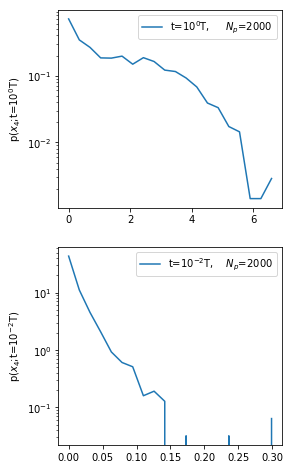

In [49]:
fig, axs = plt.subplots(len(Tsnap),1, figsize = (4,4*len(Tsnap)))
l_ = 0
for t_ in [1.0, 0.01] :
    ax = axs[l_]
    [x_, y_] = Extract_pdf(Xsnap[t_], 20)
    ax.semilogy(x_, y_, label = 't='+v_to_pow(t_)+'T,\t $N_p$='+str(MP_params['Np']))
    ax.set_ylabel(r'p($x_'+str(d_+1)+'$;t='+v_to_pow(t_)+'T)')
    ax.legend()
    l_ += 1
    print(np.mean(Xsnap[t_]))